# SBA Loan Analysis

# Modeling - Part 4 - CatBoost

## Table of Contents

1. Imports
2. Previewing Data
3. Preprocessing Data
    1. Standard Scaler
    2. Robust Scaler
4. Evaluation Metrics
5. Simple Model
    1. Standard Scaler
    2. Robust Scaler
6. Grid Search
    1. Standard Scaler
    2. Robust Scaler
7. Bayesian Optimization
    1. Standard Scaler
    2. Robust Scaler
8. Save Results
    

## 1. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

from library.preprocessing import processing_pipeline
from library.modeling import (createModel, createClassificationMetrics,
                             runGridSearchAnalysis, createConfusionMatrix, createFeatureImportanceChart,
                             appendModelingResults, drawRocCurve, obtain_best_bayes_model)

In [57]:
f = open('./results/best_params.json')
data = json.load(f)
best_model_params = dict(data)

In [3]:
model_results = []

## 2. Previewing Data

In [4]:
sba_loans = pd.read_csv('./../data/processed/sba_national_processed_final.csv')

pd.set_option('display.max_columns', None)

In [5]:
sba_loans.head()

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,NAICS_sectors,unemployment_rate,gdp_growth,gdp_annual_change,inflation_rate,inf_rate_annual_chg,NewExist_existing_business,NewExist_new_business,UrbanRural_rural,UrbanRural_urban,isFranchise_not_franchise,RevLineCr_v2_N,RevLineCr_v2_Y,LowDoc_v2_N,LowDoc_v2_Y,MIS_Status_v2_default,state_top10
0,84,4,0,0,60000.0,60000.0,48000.0,45,3.5,4.4472,0.67,2.3377,-0.59,0,1,0,0,1,1,0,0,1,0,0
1,60,2,0,0,40000.0,40000.0,32000.0,72,3.5,4.4472,0.67,2.3377,-0.59,0,1,0,0,1,1,0,0,1,0,0
2,180,7,0,0,287000.0,287000.0,215250.0,62,3.5,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,1,0,0,0
3,60,2,0,0,35000.0,35000.0,28000.0,0,4.1,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,0,1,0,0
4,240,14,7,7,229000.0,229000.0,229000.0,0,4.8,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,1,0,0,1


## 3. Preprocessing Data

In [6]:
target = 'MIS_Status_v2_default'
features = sba_loans.drop(columns='MIS_Status_v2_default', axis=1).columns

### A. Standard Scaler

In [7]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss = processing_pipeline(sba_loans, target)

### B. Robust Scaler

In [8]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = processing_pipeline(sba_loans, target, scaler='Robust')

## 4. Evaluation Metrics

The following evlaution metrics will be used to evaluate the effectiveness of the logistic models.

**Accuracy Score**

Blurb about accuracy score.

**Classifiation Report**

Blurb about Classification Report

**Matthew's Correlation Coefficient**

Blurb about MCC

**F1 Score**

Blurb about F1 Score and why it will be the main metric for evaluation

## 5. Simple Model

### A. Standard Scaler

In [9]:
cat_ss_mod1 = CatBoostClassifier(random_state=42, verbose=0)
y_pred = createModel(cat_ss_mod1, X_train_ss, y_train_ss, X_test_ss)

In [10]:
metrics = createClassificationMetrics(y_pred, y_test_ss)

In [11]:
print('Accuracy Score: ' + str(round(metrics['acc'], 4)))

Accuracy Score: 0.9499


In [12]:
print('Classification Report: \n' + metrics['cr'])

Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.97      0.97    223642
     default       0.84      0.87      0.85     45212

    accuracy                           0.95    268854
   macro avg       0.91      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854



In [13]:
print('Matthew\'s Correlation Coefficient: ' + str(round(metrics['mcc'],4)))

Matthew's Correlation Coefficient: 0.8239


In [14]:
print('F1 Score: ' + str(round(metrics['f1'], 4)))

F1 Score: 0.8539


### B. Robust Scaler

In [15]:
cbc_rs_mod1 = CatBoostClassifier(random_state=42, verbose=0)
y_pred = createModel(cbc_rs_mod1, X_train_rs, y_train_rs, X_test_rs)

In [16]:
metrics = createClassificationMetrics(y_pred, y_test_rs)

In [17]:
print('Accuracy Score: ' + str(round(metrics['acc'], 4)))

Accuracy Score: 0.9499


In [18]:
print('Classification Report: \n' + metrics['cr'])

Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.97      0.97    223763
     default       0.84      0.87      0.85     45091

    accuracy                           0.95    268854
   macro avg       0.91      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854



In [19]:
print('Matthew\'s Correlation Coefficient: ' + str(round(metrics['mcc'],4)))

Matthew's Correlation Coefficient: 0.8237


In [20]:
print('F1 Score: ' + str(round(metrics['f1'], 4)))

F1 Score: 0.8536


## 6. Grid Search Cross Validation

In [21]:
param_grid = {
    'learning_rate': [0.03, 0.1],
    'iterations': [500, 1000],
    'l2_leaf_reg': [1.0, 3.0],
    'depth': [3,6]   
}

### A. Standard Scaler

In [22]:
mod_info = {
    'model': 'CatBoost',
    'method': 'Grid Search',
    'scaler': 'Standard'
}

In [23]:
cbc = CatBoostClassifier(random_state=42, verbose=0)
cbc_ss_best_params, y_pred = runGridSearchAnalysis(cbc, param_grid, X_train_ss, y_train_ss, X_test_ss)

**Evaluation Metrics**

In [24]:
metrics = createClassificationMetrics(y_pred, y_test_ss)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

Accuracy Score: 0.9491173648151041
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.96      0.97    224037
     default       0.83      0.87      0.85     44817

    accuracy                           0.95    268854
   macro avg       0.90      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854

Matthew's Correlation Coefficient: 0.8206916936738459
F1 Score: 0.8510128512306686


**Confusion Matrix**

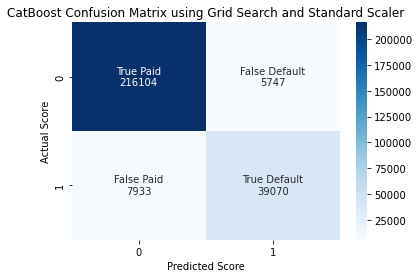

In [25]:
matrix = createConfusionMatrix(y_test_ss, y_pred, mod_info)

**ROC Curve**

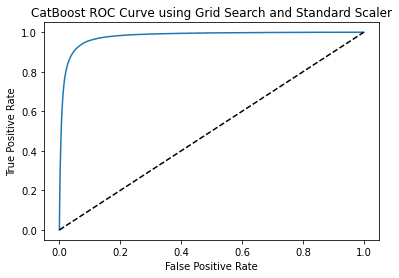

In [26]:
cbc_mod = CatBoostClassifier(**cbc_ss_best_params, random_state=42, verbose=0)
metrics['auc'] = drawRocCurve(cbc_mod, X_train_ss, X_test_ss, y_train_ss, y_test_ss, mod_info)

**Feature Importance with Best Params**

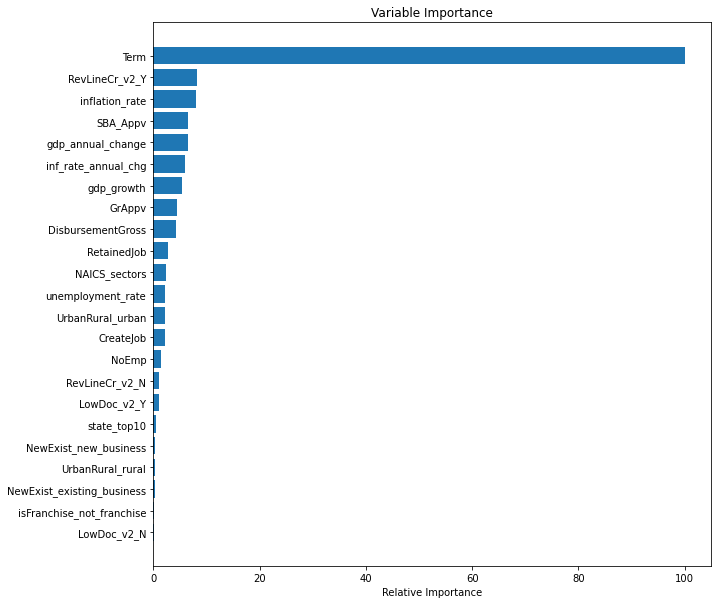

In [27]:
createFeatureImportanceChart(cbc_mod, features, X_train_ss, y_train_ss)

**Append Results**

In [28]:
model_results, best_model_params = appendModelingResults(model_results, best_model_params, mod_info, 
                                                         cbc_ss_best_params, matrix, metrics)

### B. Robust Scaler

In [29]:
mod_info = {
    'model': 'CatBoost',
    'method': 'Grid Search',
    'scaler': 'Robust'
}

In [30]:
cbc = CatBoostClassifier(random_state=42, verbose=0)
cbc_rs_best_params, y_pred = runGridSearchAnalysis(cbc, param_grid, X_train_rs, y_train_rs, X_test_rs)

**Evaluation Metrics**

In [31]:
metrics = createClassificationMetrics(y_pred, y_test_rs)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

Accuracy Score: 0.9490466944884585
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.96      0.97    224090
     default       0.83      0.87      0.85     44764

    accuracy                           0.95    268854
   macro avg       0.90      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854

Matthew's Correlation Coefficient: 0.8203775082163081
F1 Score: 0.8507197576470844


**Confusion Matrix**

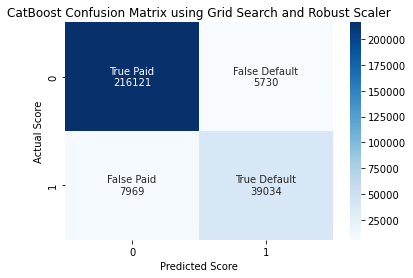

In [32]:
matrix = createConfusionMatrix(y_test_rs, y_pred, mod_info)

**ROC Curve**

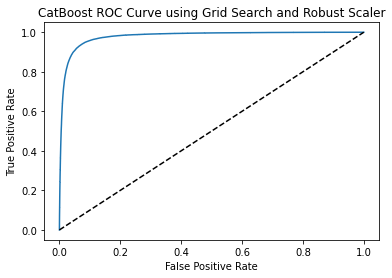

In [33]:
cbc_mod = CatBoostClassifier(**cbc_rs_best_params, random_state=42, verbose=0)
metrics['auc'] = drawRocCurve(cbc_mod, X_train_rs, X_test_rs, y_train_rs, y_test_rs, mod_info)

**Feature Importance with Best Params**

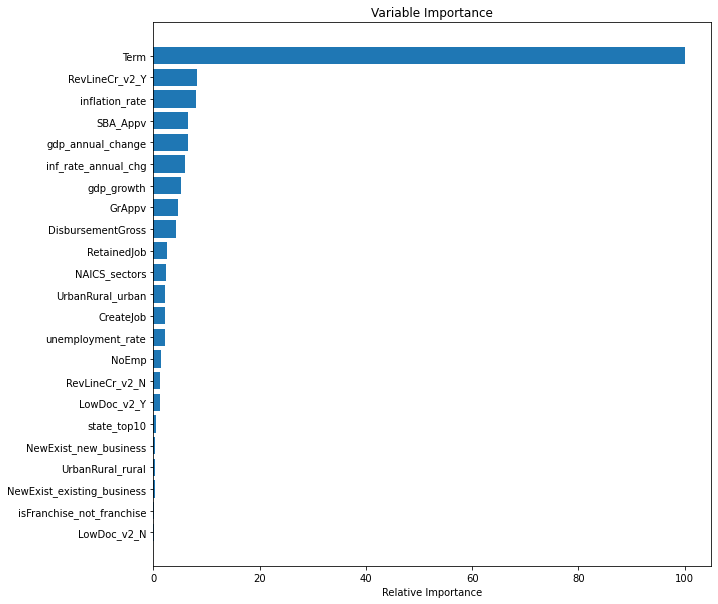

In [34]:
createFeatureImportanceChart(cbc_mod, features, X_train_rs, y_train_rs)

**Append Results**

In [35]:
model_results, best_model_params = appendModelingResults(model_results, best_model_params, mod_info, 
                                                         cbc_rs_best_params, matrix, metrics)

## 7. Bayesian Optimization

In [36]:
integer_grid = ['iterations','depth']
search_space = {
    'learning_rate': (0.03, 1.00),
    'iterations': (500, 1500),
    'l2_leaf_reg': (1.0, 5.0),
    'depth': (2,8)
}

In [37]:
def bestBayesCatboostModel(model, X_train, y_train, integer_grid, search_space):
    """
    
    """
    
    def reclassify_params(params):
        """
        
        """
        for param in params:
            if param in integer_grid:
                params[param] = round(params[param])
        return params
    
    def optimizer_func(**params):
        """
        
        """
        params = reclassify_params(params)
        
        scores = cross_val_score(model(**params, random_state=42, verbose=0),
                                 X_train,
                                 y_train,
                                 scoring='f1',
                                 cv=5
                                ).mean()
        return scores.mean()
    
    opt = BayesianOptimization(
        f=optimizer_func,
        pbounds=search_space,
        random_state=42,
        verbose=2
    )
    
    # USED FOR TESTING PURPOSES ONLY
    logger = JSONLogger(path='./lgr_opt.json')
    opt.subscribe(Events.OPTIMIZATION_STEP, logger)
    
    opt.maximize(init_points=5, n_iter=10)
    
    best_params = opt.max['params']
    best_params = reclassify_params(best_params)
    return best_params

In [38]:
mod_info = {
    'model': 'CatBoost',
    'method': 'Bayesian Optimization',
    'scaler': 'Standard'
}

In [39]:
cbc_bo_ss_params = bestBayesCatboostModel(CatBoostClassifier, X_train_ss, y_train_ss, integer_grid, search_space)

In [40]:
cbc_bo_ss_mod1 = CatBoostClassifier(**cbc_bo_ss_params, random_state=42, verbose=0)
y_pred = createModel(cbc_bo_ss_mod1, X_train_ss, y_train_ss, X_test_ss)

**Evaluation Metrics**

In [41]:
metrics = createClassificationMetrics(y_pred, y_test_ss)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

Accuracy Score: 0.950073273970259
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.97      0.97    223620
     default       0.84      0.87      0.85     45234

    accuracy                           0.95    268854
   macro avg       0.91      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854

Matthew's Correlation Coefficient: 0.8245748908677762
F1 Score: 0.8544727170224531


**Confusion Matrix**

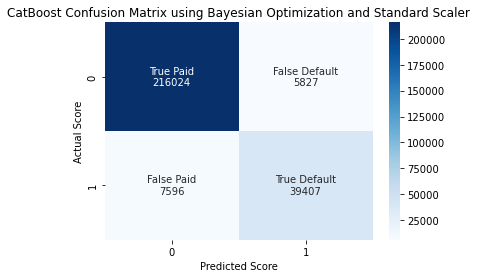

In [42]:
matrix = createConfusionMatrix(y_test_ss, y_pred, mod_info)

**ROC Curve**

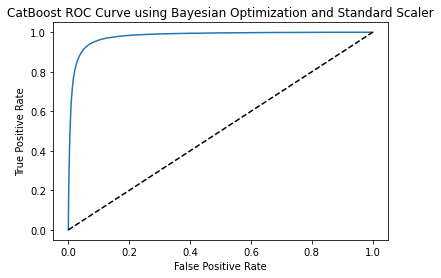

In [43]:
metrics['auc'] = drawRocCurve(cbc_bo_ss_mod1, X_train_ss, X_test_ss, y_train_ss, y_test_ss, mod_info)

**Feature Importance with Best Params**

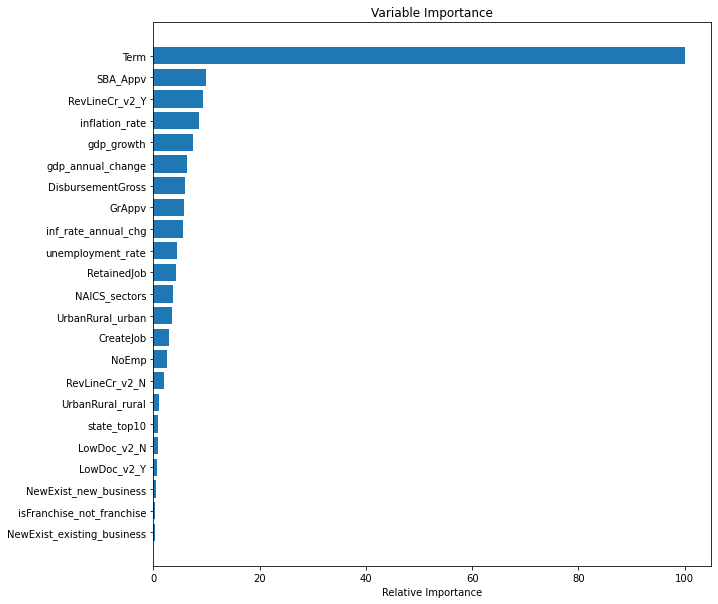

In [44]:
createFeatureImportanceChart(cbc_bo_ss_mod1, features, X_train_ss, y_train_ss)

**Append Results**

In [45]:
model_results, best_model_params = appendModelingResults(model_results, best_model_params, mod_info, 
                                                         cbc_bo_ss_params, matrix, metrics)

### B. Robust Scaler

In [46]:
mod_info = {
    'model': 'CatBoost',
    'method': 'Bayesian Optimization',
    'scaler': 'Robust'
}

In [64]:
cbc_bo_rs_params = bestBayesCatboostModel(CatBoostClassifier, X_train_rs, y_train_rs, integer_grid, search_space)

In [65]:
cbc_bo_rs_mod1 = CatBoostClassifier(**cbc_bo_rs_params, random_state=42, verbose=0)
y_pred = createModel(cbc_bo_rs_mod1, X_train_rs, y_train_rs, X_test_rs)

**Evaluation Metrics**

In [66]:
metrics = createClassificationMetrics(y_pred, y_test_rs)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

Accuracy Score: 0.9504972959301331
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.97      0.97    223698
     default       0.84      0.87      0.86     45156

    accuracy                           0.95    268854
   macro avg       0.91      0.92      0.91    268854
weighted avg       0.95      0.95      0.95    268854

Matthew's Correlation Coefficient: 0.8259716004461466
F1 Score: 0.8555865406525678


**Confusion Matrix**

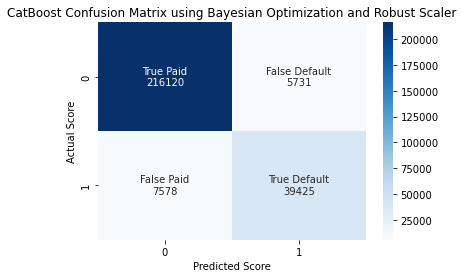

In [67]:
matrix = createConfusionMatrix(y_test_rs, y_pred, mod_info)

**ROC Curve**

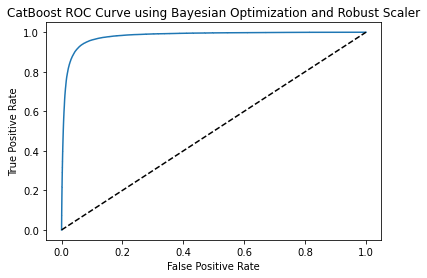

In [68]:
metrics['auc'] = drawRocCurve(cbc_bo_rs_mod1, X_train_rs, X_test_rs, y_train_rs, y_test_rs, mod_info)

**Feature Importance with Best Params**

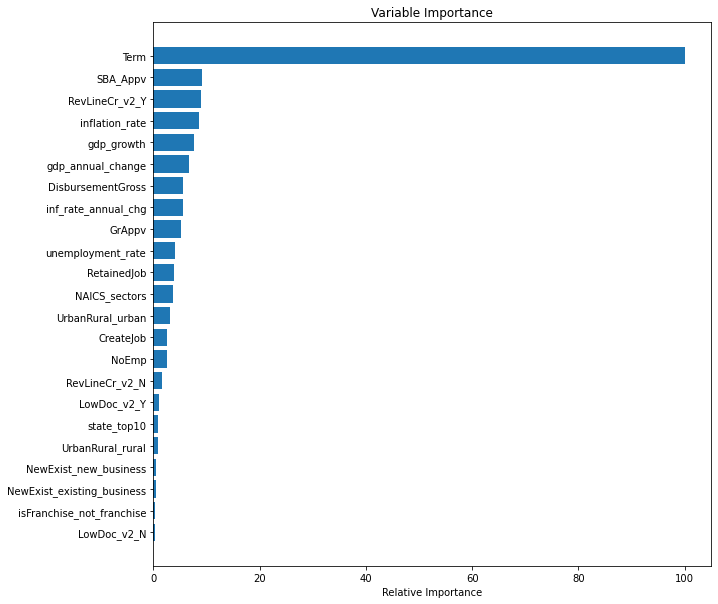

In [69]:
createFeatureImportanceChart(cbc_bo_rs_mod1, features, X_train_rs, y_train_rs)

**Append Results**

In [70]:
model_results, best_model_params = appendModelingResults(model_results, best_model_params, mod_info, 
                                                         cbc_bo_rs_params, matrix, metrics)

## 8. Save Results

In [76]:
all_model_results = pd.read_csv('./results/model_results.csv')
model_results = pd.DataFrame(model_results)
all_model_results = pd.concat([all_model_results, model_results])
all_model_results = all_model_results.reset_index(drop=True)

In [73]:
all_model_results.to_csv('./results/model_results.csv')
with open('./results/best_params.json', 'w') as outfile:
    json.dump(best_model_params, outfile, indent)

{'Logistic Regression': {'Grid Search': {'Standard': {'C': 0.001,
    'fit_intercept': False,
    'penalty': 'none',
    'solver': 'saga'},
   'Robust': {'C': 0.001,
    'fit_intercept': False,
    'penalty': 'l1',
    'solver': 'saga'}},
  'Bayesian Optimization': {'Standard': {'C': 31.567897812394946,
    'fit_intercept': False,
    'penalty': 'l2',
    'solver': 'saga'},
   'Robust': {'C': 37.454637344617396,
    'fit_intercept': False,
    'penalty': 'l1',
    'solver': 'saga'}}},
 'Random Forest': {'Grid Search': {'Standard': {'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'auto'},
   'Robust': {'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'auto'}},
  'Bayesian Optimization': {'Standard': {'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'log2'},
   'Robust': {'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'log2'}}},
 'XGBoost': {'Grid Search': {'Standard': {'learning_rate': 0.1,
    'max_depth': 10,
 